In [1]:
import tarfile
import os

extract_dir = "data/extracted/"

for archive in os.listdir("data"):
    if archive.endswith(".gz"):
        archive = f"data/{archive}"
        try:
            with tarfile.open(archive, "r:gz") as tar:
                tar.extractall(path=extract_dir)
                print(f"{archive} extracted to: {extract_dir}")
        
        except Exception as e:
            print(f"Error: {e} extracting {archive}")

data/cv-corpus-20.0-2024-12-06-en.tar.gz extracted to: data/extracted/
data/test-clean.tar.gz extracted to: data/extracted/
data/train-clean-360.tar.gz extracted to: data/extracted/
data/dev-clean.tar.gz extracted to: data/extracted/


Two datasets were downloaded, but so far only a portion of the CommonVoice dataset has been used.

In [2]:
import re
import h5py
from typing import Union, Optional, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

pd.options.display.float_format = '{:.2f}'.format

audio_files_dir = "data/extracted/cv-corpus-20.0-2024-12-06/en/clips/"
char_to_num = {char: idx + 1 for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
char_to_num['<PAD>'] = 0
n_mfcc = 13

In [3]:
def clean_transcription(text: str):
    """Cleans labels from characters other than letters and spaces, normalizes to lower case."""
    text = re.sub(r'[^\w\s]', "", text)
    return text.lower()


def get_features_and_label(audio_filename: str, raw_label: str):
    """Extracts MFCC representation from data and encodes labels"""
    audio_file_path = f'{audio_files_dir}{audio_filename}'
    audio_time_series, sample_rate = librosa.load(audio_file_path, sr=16000)
    
    # mfcc extraction
    mfcc = librosa.feature.mfcc(y=audio_time_series, sr=sample_rate, n_mfcc=n_mfcc)
    
    # label
    label = np.array([char_to_num.get(char, 28) for char in raw_label], dtype="uint8")

    return mfcc, label
    

def get_data(info_df: pd.DataFrame, n_samples: int = None, data_frac: float = None):
    """Extracts the desired data sample size."""
    X = []
    y = []

    df = info_df.sample(n=n_samples, frac=data_frac, random_state=42)

    for sample in df.itertuples():
        mfcc, label = get_features_and_label(sample.path, sample.clean_sentence)
        X.append(mfcc)
        y.append(label)

    return X, y, df

# CommonVoice

Filtering data for pre-testing: only samples with 0 down votes and at least 2 up votes, no shortest or longest transcriptions (to limit padding), only accent marked as United States.

In [5]:
df = pd.read_csv(f"data/extracted/cv-corpus-20.0-2024-12-06/en/train.tsv",
                  sep='\t', low_memory=False)
print(len(df))
df.head(3)

1124128


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,e10a9295913c988f3e3d0966e91d30ecf44ebcf21ba629...,common_voice_en_26405174.mp3,9818e25778694555af96b849fcf063dcb6006e8a56de14...,"There were coupe, sedan, and station wagon mod...",NaN,2,1,NaN,NaN,NaN,NaN,en,NaN
1,e10a9295913c988f3e3d0966e91d30ecf44ebcf21ba629...,common_voice_en_26405176.mp3,983521a95648ca156d19d70642bfd1a56a7904c9c1e61b...,His descendants and ideas would dominate class...,NaN,2,1,NaN,NaN,NaN,NaN,en,NaN
2,e10a9295913c988f3e3d0966e91d30ecf44ebcf21ba629...,common_voice_en_26405179.mp3,97cd78fb471c212cc0dc499b4bd2cd408d37717e982e35...,Or was it?,NaN,2,1,NaN,NaN,NaN,NaN,en,NaN


In [6]:
df = df[(df.down_votes == 0) & (df.up_votes >= 2)]
df["clean_sentence"] = df.sentence.apply(clean_transcription)
df = df[df['clean_sentence'].apply(lambda x: bool(re.match("^[a-z ]+$", x)))].reset_index(drop=True)
df["num_characters"] = df.clean_sentence.map(len)
df = df[(df.num_characters <= 110) & (df.num_characters >= 10)]

print(len(df))
df.accents.value_counts()[:10]

955625


accents
United States English                                 250895
England English                                        76591
India and South Asia (India, Pakistan, Sri Lanka)      62282
Canadian English                                       51552
Non native speaker,German English                      43152
Australian English                                     29321
Southern African (South Africa, Zimbabwe, Namibia)     18857
Northern Irish                                          9512
Scottish English                                        8480
Irish English                                           6029
Name: count, dtype: int64

In [7]:
df = df[df.accents == "United States English"]
df = df.sample(frac=.5, random_state=42) # random 50% for pre-testing
df.to_csv("selected_shuffled.csv", index=False)

### Filtered data

In [4]:
df = pd.read_csv("selected_shuffled.csv", low_memory=False)
train_, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_, test_size=0.1, random_state=42)

len(train), len(val), len(test)

(90322, 10036, 25090)

In [9]:
sample_rates = []

for sample in train.itertuples():
    audio_file_path = f'{audio_files_dir}{sample.path}'
    _, sample_rate = librosa.load(audio_file_path, sr=None)
    
    sample_rates.append(sample_rate)

np.mean(sample_rates), np.max(sample_rates), np.min(sample_rates)

(np.float64(41490.798476561635), np.int64(48000), np.int64(32000))

Wav length: 97280


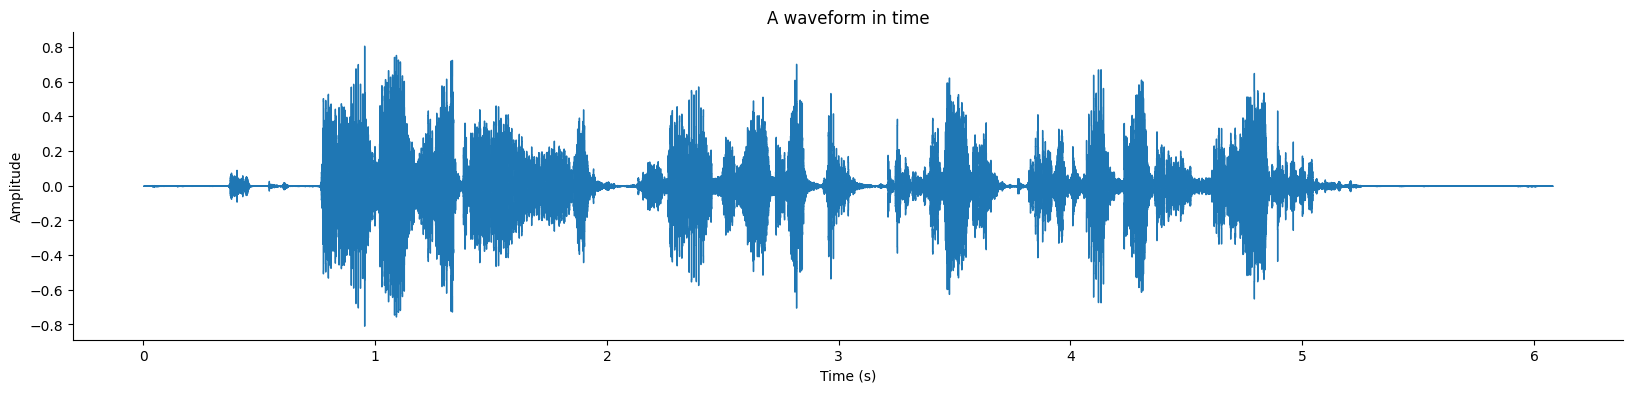

MFCC size: (13, 202)


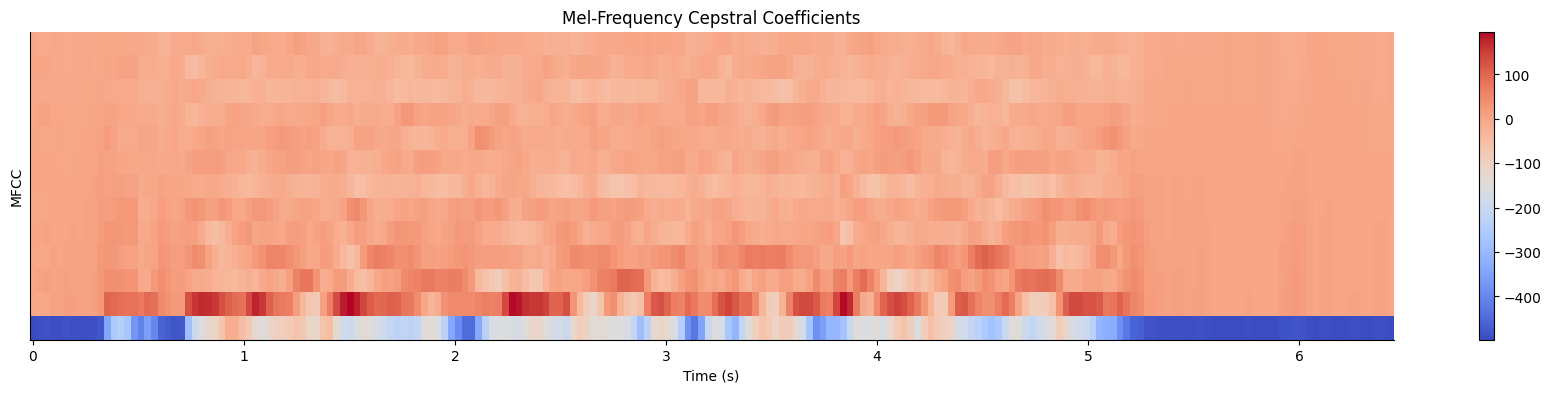

Mel spectrogram shape: (128, 191)


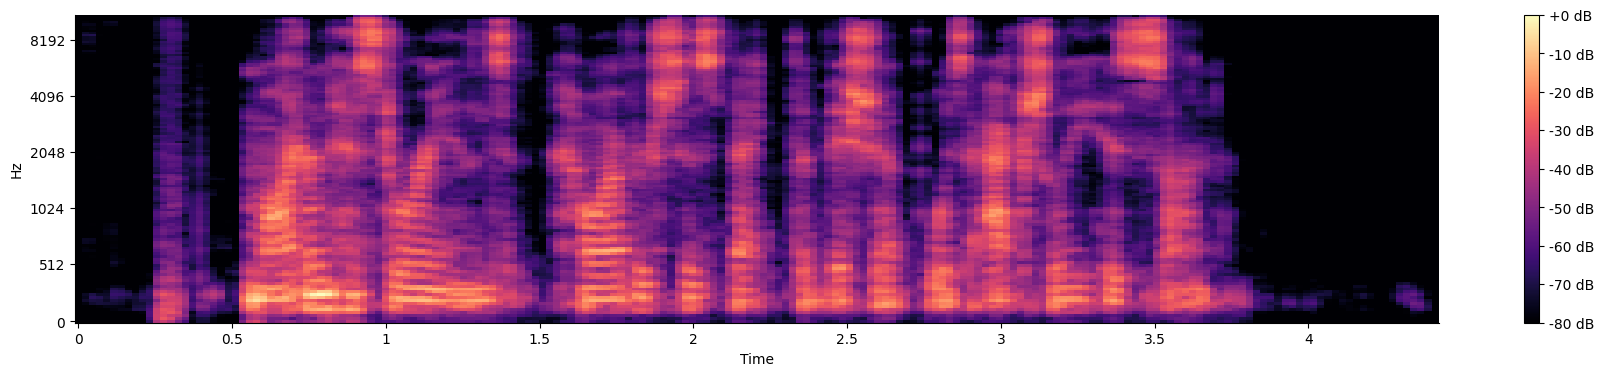

Label:
modern historians however suspect the bishop was actually his son
Encoded label:
[13 15  4  5 18 14 27  8  9 19 20 15 18  9  1 14 19 27  8 15 23  5 22  5
 18 27 19 21 19 16  5  3 20 27 20  8  5 27  2  9 19  8 15 16 27 23  1 19
 27  1  3 20 21  1 12 12 25 27  8  9 19 27 19 15 14] 



In [10]:
for sample in train.sample(1).itertuples():

    # data
    audio_file_path = f'{audio_files_dir}{sample.path}'
    audio_time_series, sample_rate = librosa.load(audio_file_path, sr=16000)
    audio_time_series, _ = librosa.effects.trim(audio_time_series)
    print(f"Wav length: {len(audio_time_series)}")

    plt.figure(figsize=(20, 4))
    librosa.display.waveshow(audio_time_series, sr=sample_rate)
    plt.title("A waveform in time")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # mfcc extraction
    mfcc, transcript = get_features_and_label(sample.path, sample.clean_sentence)
    print(f"MFCC size: {mfcc.shape}")
    
    plt.figure(figsize=(22, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title("Mel-Frequency Cepstral Coefficients")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC")
    plt.show()

    mel_spectr = librosa.feature.melspectrogram(y=audio_time_series, sr=sample_rate,
                                                n_mels=128, fmax=8000)
    print(f"Mel spectrogram shape: {mel_spectr.shape}")
    
    plt.figure(figsize=(22, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectr, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
    print("Label:")
    print(sample.clean_sentence)
    print("Encoded label:")
    print(transcript, "\n")

Audio(audio_time_series, rate=sample_rate)

# MFCC - compact representation of audio signal features

Mel Frequency Cepstral Coefficient (MFCC) is a feature extraction method for speech signals that mimics the way the human ear interprets sounds. These data capture the properties of speech signals, such as power, pitch, and the shape of the vocal tract, considering the human ear's varying sensitivity to low and high frequencies. By transforming frequencies to the Mel scale and applying spectral analysis and cosine transformation, MFCC enables the extraction of the most important acoustic features useful for speech recognition.

For example, the first coefficient represents the energy of the entire signal or the average spectral power. It can be seen as a measure of the signal's loudness. The subsequent coefficients represent the overall slope of the spectrum and its modulation. These features distinguish different voices or timbres of sound. Later coefficients delve into more detailed aspects of the spectrum, such as "waviness" or subtle details related to harmonics or noise.

In [11]:
train[["path", "sentence", "clean_sentence", "num_characters"]].head(3)

,path,sentence,clean_sentence,num_characters
122807,common_voice_en_20205148.mp3,Its definition can also include the northweste...,its definition can also include the northweste...,81
102777,common_voice_en_21304248.mp3,The highest point of the city is Cambirela mou...,the highest point of the city is cambirela mou...,77
108156,common_voice_en_22274885.mp3,The storylines in the early films were loosely...,the storylines in the early films were loosely...,79


In [5]:
X_train, y_train, _ = get_data(train, n_samples=len(train))
X_val, y_val, _ = get_data(train, n_samples=len(val))
X_test, y_test, _ = get_data(train, n_samples=len(test))

In [13]:
for sample in X_train[:5]:
    print(sample.shape)

(13, 208)
(13, 68)
(13, 159)
(13, 134)
(13, 119)


In [14]:
X_train[0], y_train[0]

(array([[-5.0189679e+02, -4.0231543e+02, -3.7673904e+02, ...,
         -2.4770570e+02, -2.5037634e+02, -2.8840982e+02],
        [ 6.2136509e+01,  7.1693069e+01,  6.8853363e+01, ...,
          8.0465988e+01,  7.4809219e+01,  6.4703178e+01],
        [ 2.7700199e+01,  2.6513012e+01,  2.6009964e+01, ...,
          1.4295132e+01,  1.4278120e+01,  7.5151267e+00],
        ...,
        [ 2.8381190e+00,  3.6318407e+00,  1.3762293e+00, ...,
         -7.8946495e+00, -6.5805979e+00, -1.6977332e+00],
        [-3.5095167e+00,  5.1858926e-01,  2.5574265e+00, ...,
         -4.0342730e-01, -2.7085569e+00,  1.4194185e+00],
        [ 3.7204285e+00,  1.0513062e+01,  6.0958309e+00, ...,
         -7.5488186e-01, -3.3735120e+00,  5.9962785e-01]], dtype=float32),
 array([20,  8,  5, 27, 19, 20,  1, 20,  9, 15, 14, 27,  2, 21,  9, 12,  4,
         9, 14,  7, 27, 18,  5, 13,  1,  9, 14, 19, 27,  9, 14, 27, 16, 18,
         9, 22,  1, 20,  5, 27, 15, 23, 14,  5, 18, 19,  8,  9, 16, 27,  1,
        14,  4, 27,  1

In [1]:
# mel_coefs = np.concatenate(X_val, axis=1)
# fig, axes = plt.subplots(3, 5, figsize=(20, 8))

# axes = axes.flatten()

# for i in range(n_mfcc):
#     axes[i].hist(mel_coefs, bins=100)
#     axes[i].set_title(f"MFCC {i+1}")
# for i in range(n_mfcc, len(axes)):
#     axes[i].set_axis_off()
# plt.tight_layout();

In [24]:
scaler = StandardScaler()
scaler.fit(np.vstack([sample.T for sample in X_train])) 

X_train_scaled = [scaler.transform(sample.T) for sample in X_train]
X_val_scaled = [scaler.transform(sample.T) for sample in X_val]
X_test_scaled = [scaler.transform(sample.T) for sample in X_test]

In [25]:
scaler.mean_, scaler.scale_

(array([-343.62242343,   78.21253244,    0.4839011 ,   22.07770336,
          -4.99473198,   -3.08054412,  -12.00887088,   -7.41603405,
          -7.52357172,   -3.84087555,   -7.9314353 ,   -2.18467336,
          -5.20115051]),
 array([169.14487326,  71.67636687,  41.56370866,  36.02731817,
         26.74341144,  22.01527854,  21.2649433 ,  18.64448509,
         16.04468386,  14.36305494,  13.42850062,  11.84147428,
         11.4662927 ]))

## Saving MFCC dataset

The data was saved in HDF5 format to facilitate easy loading into the dataset for the model.

In [27]:
def sort_data(X, y, idx):
    
    order = sorted(range(len(X)), key=lambda i: X[i].shape[0])
    X_sorted = [X[i] for i in order]
    y_sorted = [y[i] for i in order]
    idxs_sorted = [idx[i] for i in order]

    return X_sorted, y_sorted, idxs_sorted


def save_data(save_path, X, y, df_idxs):

    X, y, df_idxs = sort_data(X, y, df_idxs)

    with h5py.File(save_path, "w") as hf:
        mfcc_group = hf.create_group("mfcc")
        labels_group = hf.create_group("labels")
        
        i = 0
        for mfcc, label, idx in zip(X, y, df_idxs):
            mfcc_group.create_dataset(str(idx), data=mfcc, compression="gzip")
            labels_group.create_dataset(str(idx), data=label, compression="gzip")
            i += 1

    print(f"Saved: {save_path} with {i} samples.")

save_data("data/CommonVoice/train.h5", X_train_scaled, y_train, train.index.values)
save_data("data/CommonVoice/val.h5", X_val_scaled, y_val, val.index.values)
save_data("data/CommonVoice/test.h5", X_test_scaled, y_test, test.index.values)

Saved: data/CommonVoice/train.h5 with 90322 samples.
Saved: data/CommonVoice/val.h5 with 10036 samples.
Saved: data/CommonVoice/test.h5 with 25090 samples.
